# Step Detection Log Analysis

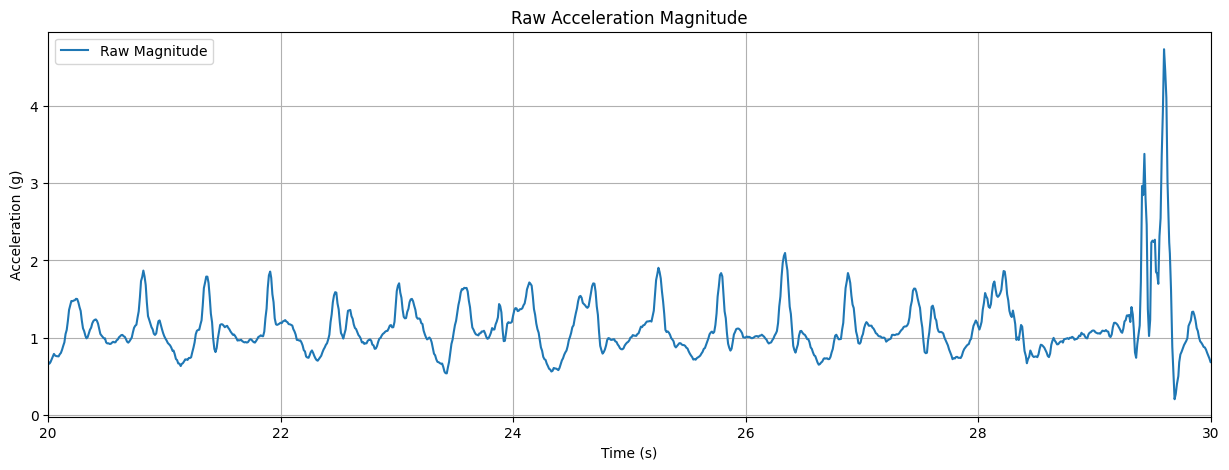

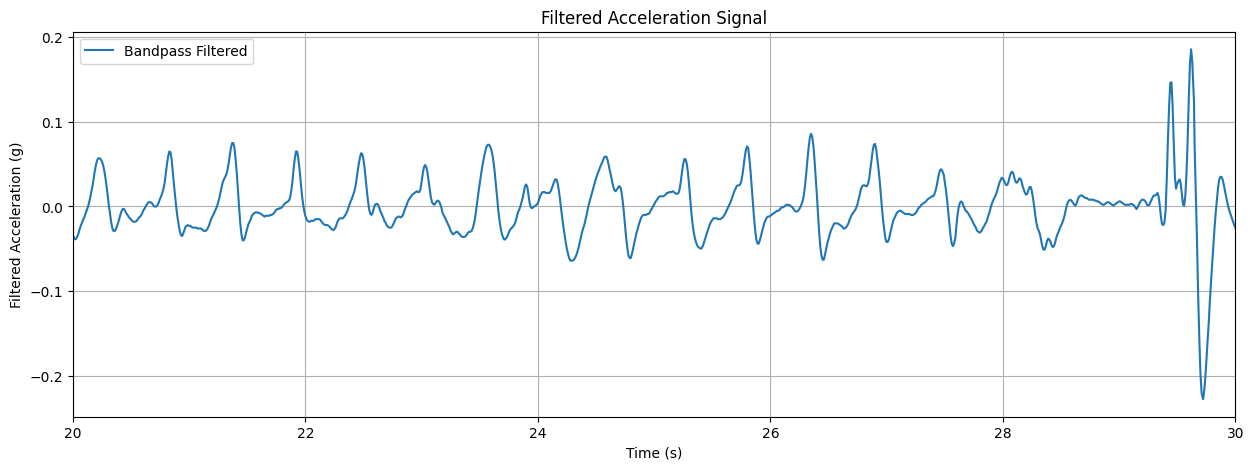

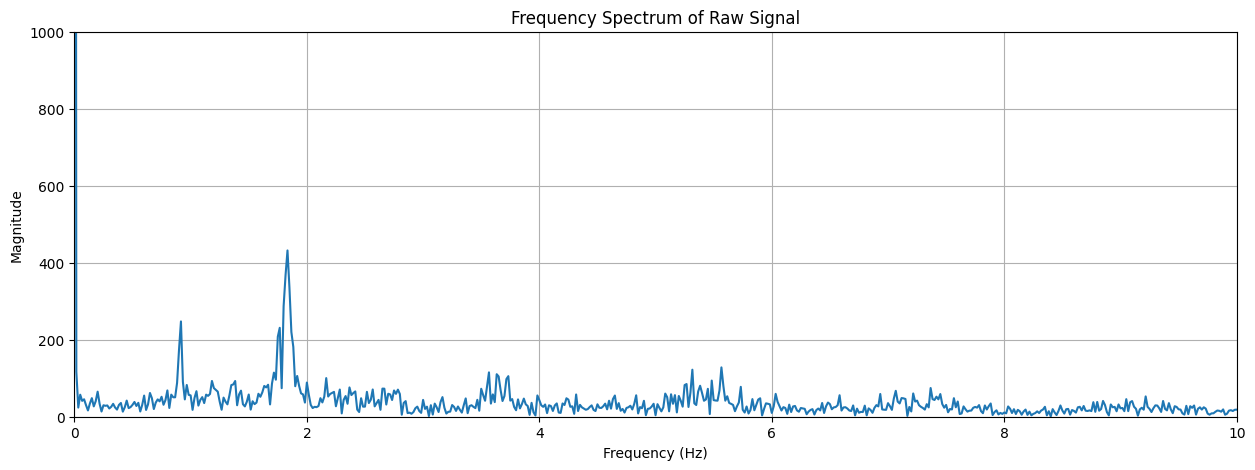

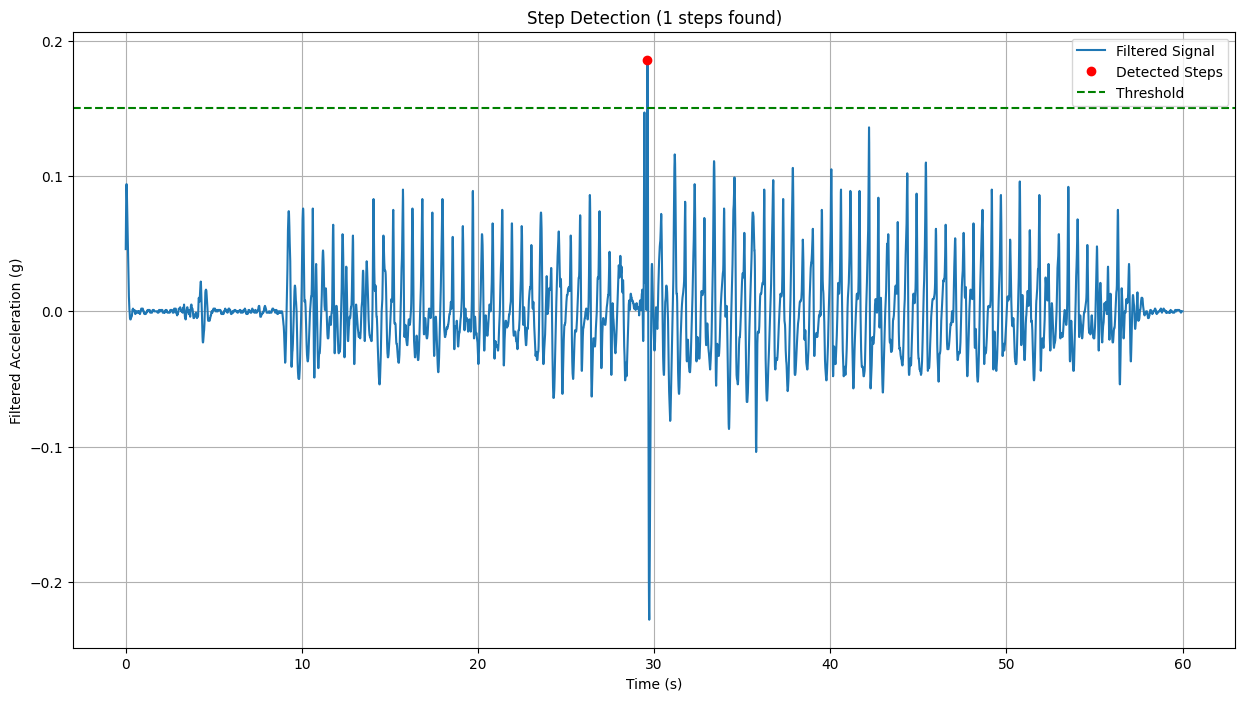

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq

# Load the data
df = pd.read_csv('imu_log_20250615_175856.csv')  # Replace with your actual filename

# Convert timestamp to seconds and create time axis
df['timestamp_s'] = df['timestamp_us'] / 1e6
df['time_elapsed'] = df['timestamp_s'] - df['timestamp_s'].iloc[0]

start = 20
end = start + 10

# Raw vs Filtered Signal Visualization
plt.figure(figsize=(15, 5))
plt.plot(df['time_elapsed'], df['raw_mag'], label='Raw Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Raw Acceleration Magnitude')
plt.legend()
plt.grid(True)
plt.xlim(start, end)
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(df['time_elapsed'], df['filtered'], label='Bandpass Filtered')
plt.xlabel('Time (s)')
plt.ylabel('Filtered Acceleration (g)')
plt.title('Filtered Acceleration Signal')
plt.legend()
plt.grid(True)
plt.xlim(start, end)
plt.show()

# Frequency Domain Analysis
sample_rate = 100  # Hz (from your 10ms sample period)
n = len(df)
yf = fft(df['raw_mag'].values)
xf = fftfreq(n, 1/sample_rate)

plt.figure(figsize=(15, 5))
plt.plot(xf[:n//2], np.abs(yf[:n//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of Raw Signal')
plt.xlim(0, 10)  # Focus on 0-10Hz range
plt.ylim(0, 1000)
plt.grid(True)
plt.show()

# Step Detection Simulation
threshold = 0.15  #threshold from C code
min_step_interval = 0.3  # 300ms in seconds

# Find peaks in the filtered signal
peaks, _ = signal.find_peaks(df['filtered'], height=threshold, distance=int(min_step_interval*sample_rate))

# Plot with detected steps
plt.figure(figsize=(15, 8))
plt.plot(df['time_elapsed'], df['filtered'], label='Filtered Signal')
plt.plot(df['time_elapsed'].iloc[peaks], df['filtered'].iloc[peaks], 
         'ro', label='Detected Steps')
plt.axhline(threshold, color='g', linestyle='--', label='Threshold')
plt.xlabel('Time (s)')
plt.ylabel('Filtered Acceleration (g)')
plt.title(f'Step Detection ({len(peaks)} steps found)')
plt.legend()
plt.grid(True)
plt.show()

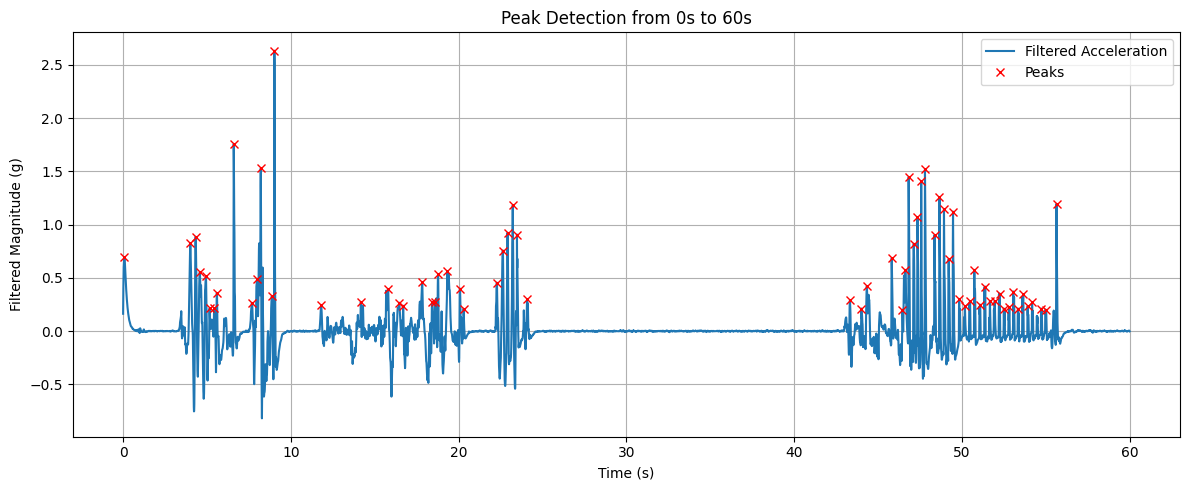

Detected steps: 67


In [ ]:
from scipy.signal import find_peaks
start_time = 0    
end_time = 60   

# Filter the DataFrame for the specified time range
df_window = df[(df['time_s'] >= start_time) & (df['time_s'] <= end_time)]

# Try basic detection
peaks, _ = find_peaks(df_window['filtered_mag'], height=0.2, distance=15)  # adjust height & distance as needed

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_window['time_s'], df_window['filtered_mag'], label='Filtered Acceleration')
plt.plot(df_window['time_s'].iloc[peaks], df_window['filtered_mag'].iloc[peaks], "rx", label='Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Filtered Magnitude (g)')
plt.title(f'Peak Detection from {start_time}s to {end_time}s')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Detected steps:", len(peaks))


In [9]:
import scipy.signal as sig

# Sample rate 
fs = 100  

# Design new bandpass filter 
lowcut = 0.5  # Lower cutoff (Hz) - typical walking starts at 1Hz
highcut = 4   # Upper cutoff (Hz) - brisk walking/slow running
order = 2       # 2nd-order filter 

# Generate new coefficients
b, a = sig.butter(order, [lowcut, highcut], btype='bandpass', fs=fs)
print("New coefficients:")
print(f"#define BP_B0  {b[0]:.6f}f")
print(f"#define BP_B1  {b[1]:.6f}f")
print(f"#define BP_B2  {b[2]:.6f}f")
print(f"#define BP_A1  {a[1]:.6f}f")
print(f"#define BP_A2  {a[2]:.6f}f")

New coefficients:
#define BP_B0  0.010432f
#define BP_B1  0.000000f
#define BP_B2  -0.020865f
#define BP_A1  -3.676376f
#define BP_A2  5.087648f
